In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np

IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)

In [2]:
df = pd.read_feather('logs/3.feather')
df.head()

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,i,comp,group_symbol
0,0,-3.340256,126,4.034212,tetragonal,b_a_d_e,1,3,H8V4,P4/nnc
1,1,-3.513597,126,4.034212,tetragonal,b_a_d_e,1,3,H8V4,P4/nnc
2,2,-3.281660,126,4.034212,tetragonal,b_a_d_e,1,3,H8V4,P4/nnc
3,3,-3.252902,126,4.034212,tetragonal,b_a_d_e,1,3,H8V4,P4/nnc
4,4,-3.259825,126,4.034212,tetragonal,b_a_d_e,1,3,H8V4,P4/nnc


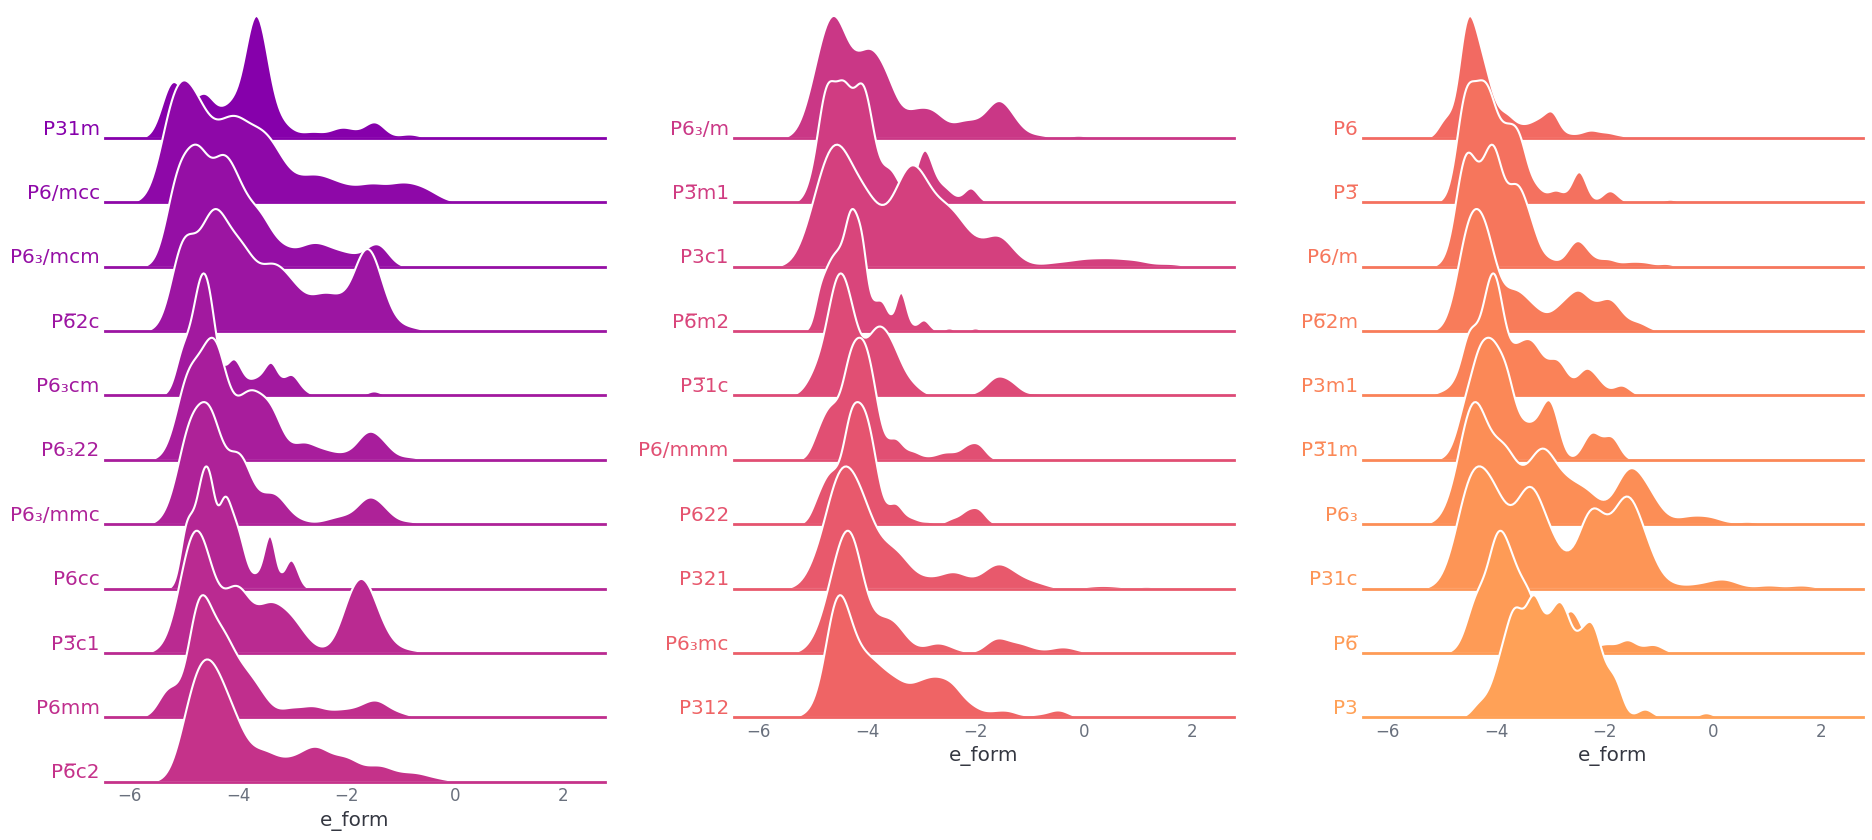

In [3]:
from baysic.viz import ridge_plot

ridge_plot(df.query('comp == "H8V4" and (lattice_type == "hexagonal")'), 'group_symbol', 'e_form', height=5)

In [4]:
from xenonpy.datatools import preset
from xenonpy.descriptor import Compositions

cal = Compositions()

print(cal)

Compositions:
  |- composition:
  |  |- Counting
  |  |- WeightedAverage
  |  |- WeightedSum
  |  |- WeightedVariance
  |  |- GeometricMean
  |  |- HarmonicMean
  |  |- MaxPooling
  |  |- MinPooling


In [5]:
import pandas as pd
from pymatgen.core import Composition
from xenonpy.descriptor import Compositions
import torch
from torch import utils
from pyro import distributions as dist
import lightning.pytorch as pl
import logging

logging.basicConfig(level=logging.DEBUG, force=True)

class EFormDataset(utils.data.Dataset):
    def __init__(self, data_path, e_form_min = -10, e_form_max = 15):
        super().__init__()
        self.data_path = data_path
        self.e_form_min = e_form_min
        self.e_form_max = e_form_max
        self.df = pd.read_feather(self.data_path).set_index(['comp', 'group_num', 'comp_ind'])[['e_form']]
        self.df_groups = self.df.loc[:, :, 0]
        self.formulas = pd.unique(self.df.index.get_level_values('comp'))
        self.comps = [Composition(x) for x in self.formulas]
        feats = Compositions().transform(self.comps)
        feats = torch.tensor(feats.values)
        norm_state = torch.load('precomputed/xenonpy_scale.pt')
        self.normalizer = dist.transforms.AffineTransform(
            norm_state['loc'],
            norm_state['scale'])
        self.e_form_scaler = dist.transforms.AffineTransform(
            -self.e_form_min / (self.e_form_max - self.e_form_min),
            1 / (self.e_form_max - self.e_form_min)
        )
        self.feats = self.normalizer(feats).float()
        self.formula_inds = {form: i for i, form in enumerate(self.formulas)}

    def __len__(self):
        return len(self.df_groups.index)

    def __getitem__(self, idx):
        comp, group = self.df_groups.index[idx]
        subset = self.df.loc[comp, group, :]
        y = torch.tensor(subset['e_form'])
        y = self.e_form_scaler(y.clamp(self.e_form_min, self.e_form_max).reshape(-1))
        X_comp = self.feats[self.formula_inds[comp]]
        X_group = torch.tensor(group)
        return (X_comp, X_group, y)

from pathlib import Path
from math import ceil

def collate(batch):
    X_comps = []
    X_groups = []
    ys = []

    for X_comp, X_group, y in batch:
        num_vals = y.numel()
        X_comps.append(X_comp.reshape(1, -1).expand(num_vals, -1))
        X_groups.append(X_group.reshape(1, -1).expand(num_vals, -1))
        ys.append(y.reshape(-1, 1))

    X_comp = torch.cat(X_comps, dim=0)
    X_group = torch.cat(X_groups, dim=0)
    y = torch.cat(ys, dim=0)
    return (X_comp, X_group, y)


class EFormDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = 'logs/', batch_size = 10, val_frac = 0.1, e_form_min = -10, e_form_max = 10, min_num=1, max_num=250):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.val_frac = val_frac
        self.batch_size = batch_size
        self.e_form_min = e_form_min
        self.e_form_max = e_form_max
        self.min_num = min_num
        self.max_num = max_num
        self.kwargs = dict(collate_fn=collate, num_workers=3, batch_size=self.batch_size)
        self.save_hyperparameters()
    def setup(self, stage: str):
        self.file_names = []
        for i in range(self.min_num, self.max_num + 1):
            i_path = self.data_dir / f'{i}.feather'
            if i_path.exists():
                self.file_names.append(i_path)

        num_val = ceil(self.val_frac * len(self.file_names))
        num_train = len(self.file_names) - num_val
        datasets = [EFormDataset(path, self.e_form_min, self.e_form_max)
                    for path in self.file_names]
        if stage == "fit":
            self.train_set = utils.data.ConcatDataset(datasets[:num_train])
            self.val_set = utils.data.ConcatDataset(datasets[num_train:])
        elif stage == "test":
            self.test_set = utils.data.ConcatDataset(datasets)

    def train_dataloader(self):
        return utils.data.DataLoader(self.train_set, shuffle=True, **self.kwargs)

    def val_dataloader(self):
        return utils.data.DataLoader(self.val_set, shuffle=False, **self.kwargs)

    def test_dataloader(self):
        return utils.data.DataLoader(self.test_set, shuffle=False, **self.kwargs)

dm = EFormDataModule(max_num=10)
dm.setup('fit')
sample_batch = next(iter(dm.train_dataloader()))
print([x.shape for x in sample_batch])
sample_batch

[torch.Size([1534, 290]), torch.Size([1534, 1]), torch.Size([1534, 1])]


(tensor([[ 0.5799, -0.3728,  0.4796,  ..., -0.3276,  0.7267,  0.3374],
         [ 0.5799, -0.3728,  0.4796,  ..., -0.3276,  0.7267,  0.3374],
         [ 0.5799, -0.3728,  0.4796,  ..., -0.3276,  0.7267,  0.3374],
         ...,
         [-0.9543,  0.2630, -1.0928,  ..., -0.3770, -1.2486, -0.8614],
         [-0.9543,  0.2630, -1.0928,  ..., -0.3770, -1.2486, -0.8614],
         [-0.9543,  0.2630, -1.0928,  ..., -0.3770, -1.2486, -0.8614]]),
 tensor([[  6],
         [  6],
         [  6],
         ...,
         [115],
         [115],
         [115]]),
 tensor([[0.3090],
         [0.3069],
         [0.3078],
         ...,
         [0.3937],
         [0.3975],
         [0.3993]], dtype=torch.float64))

In [6]:
import torch
from torch import nn, optim, utils
from pyro import distributions as dist
from torch.nn import functional as F
import lightning.pytorch as pl
import zuko

In [7]:
# https://github.com/tonyduan/mixture-density-network/blob/master/src/blocks.py

from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


class MixtureDensityNetwork(nn.Module):
    """
    Mixture density network.

    [ Bishop, 1994 ]

    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    """
    def __init__(self, dim_in, dim_out, n_components, hidden_dim, noise_type=NoiseType.DIAGONAL, fixed_noise_level=None):
        super().__init__()
        assert (fixed_noise_level is not None) == (noise_type is NoiseType.FIXED)
        num_sigma_channels = {
            NoiseType.DIAGONAL: dim_out * n_components,
            NoiseType.ISOTROPIC: n_components,
            NoiseType.ISOTROPIC_ACROSS_CLUSTERS: 1,
            NoiseType.FIXED: 0,
        }[noise_type]
        self.dim_in, self.dim_out, self.n_components = dim_in, dim_out, n_components
        self.noise_type, self.fixed_noise_level = noise_type, fixed_noise_level
        self.pi_network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_components),
        )
        self.normal_network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim_out * n_components + num_sigma_channels)
        )

    def forward(self, x, eps=1e-6):
        #
        # Returns
        # -------
        # log_pi: (bsz, n_components)
        # mu: (bsz, n_components, dim_out)
        # sigma: (bsz, n_components, dim_out)
        #
        log_pi = torch.log_softmax(self.pi_network(x), dim=-1)
        normal_params = self.normal_network(x)
        mu = normal_params[..., :self.dim_out * self.n_components]
        sigma = normal_params[..., self.dim_out * self.n_components:]
        if self.noise_type is NoiseType.DIAGONAL:
            sigma = torch.exp(sigma + eps)
        if self.noise_type is NoiseType.ISOTROPIC:
            sigma = torch.exp(sigma + eps).repeat(1, self.dim_out)
        if self.noise_type is NoiseType.ISOTROPIC_ACROSS_CLUSTERS:
            sigma = torch.exp(sigma + eps).repeat(1, self.n_components * self.dim_out)
        if self.noise_type is NoiseType.FIXED:
            sigma = torch.full_like(mu, fill_value=self.fixed_noise_level)
        mu = mu.reshape(-1, self.n_components, self.dim_out)
        sigma = sigma.reshape(-1, self.n_components, self.dim_out)
        return log_pi, mu, sigma

    def log_prob(self, x, y):
        log_pi, mu, sigma = self.forward(x)
        y = y.T.unsqueeze(-1).unsqueeze(-1)
        debug_shapes('log_pi', 'mu', 'sigma', 'y')
        z_score = (y - mu) / sigma
        normal_loglik = (
            -0.5 * torch.einsum("abij,abij->abi", z_score, z_score)
            -torch.sum(torch.log(sigma), dim=-1)
        )
        loglik = torch.logsumexp(log_pi + normal_loglik, dim=-1)
        return loglik

    def loss(self, x, y):
        return -self.log_prob(x, y)

    def sample(self, x):
        log_pi, mu, sigma = self.forward(x)
        cum_pi = torch.cumsum(torch.exp(log_pi), dim=-1)
        rvs = torch.rand(len(x), 1).to(x)
        rand_pi = torch.searchsorted(cum_pi, rvs)
        rand_normal = torch.randn_like(mu) * sigma + mu
        samples = torch.take_along_dim(rand_normal, indices=rand_pi.unsqueeze(-1), dim=1).squeeze(dim=1)
        return samples

In [17]:
import logging


logging.basicConfig(level=logging.DEBUG, force=True)

from baysic.utils import debug_shapes

class BaysicModel(pl.LightningModule):
    def __init__(self, num_clusters: int = 5, latent_dim: int = 32, lr: float = 5e-3, comp_embed_dim = 290, max_group = 230):
        super().__init__()
        L, G = latent_dim, max_group + 1
        self.lr = lr
        self.num_clusters = num_clusters
        self.num_groups = max_group
        self.latent_dim = latent_dim
        self.comp_embed_dim = comp_embed_dim
        # self.e_form_model = MixtureDensityNetwork(L + comp_embed_dim, 1, num_clusters, noise_type=NoiseType.ISOTROPIC, hidden_dim=128)
        self.e_form_model = zuko.flows.NSF(features=1, context=L + comp_embed_dim, bins=8)
        self.group_mu = nn.Parameter(dist.MultivariateNormal(torch.zeros(L), torch.eye(L)).sample((G,)))
        self.save_hyperparameters()

    def process_input(self, X_comp, X_group):
        group_emb = self.group_mu[X_group.reshape(-1)]
        # debug_shapes('mu_x', 'mu_y')
        mdn_x = torch.cat([X_comp, group_emb], dim=-1)
        return mdn_x

    def predict(self, X_comp, X_group):
        return self.e_form_model(self.process_input(X_comp, X_group).float())

    def loss(self, batch, batch_idx=None):
        X_comp, X_group, y = batch
        mdn_x = self.process_input(X_comp, X_group)

        debug_shapes('mdn_x', 'X_comp', 'X_group')
        return -self.e_form_model(mdn_x.float()).log_prob(y.float()).mean()

    def training_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

sample_batch_idx = torch.arange(dm.batch_size)
model = BaysicModel()
# model.init_on_device()
print(model.training_step(sample_batch, sample_batch_idx))

max_shape_len = max([t.ndim for n, t in model.named_parameters()])
for n, t in model.named_parameters():
    n_pad = max_shape_len - t.ndim
    print(f'{n:>40}', ' '.join([f'{s:>4}' for s in [''] * n_pad + list(t.shape)]))

DEBUG:root:  mdn_x = 1534  322
DEBUG:root: X_comp = 1534  290
DEBUG:root:X_group = 1534    1


tensor(1.0531, grad_fn=<NegBackward0>)
                                group_mu  231   32
e_form_model.transform.transforms.0.hyper.0.weight   64  323
e_form_model.transform.transforms.0.hyper.0.bias        64
e_form_model.transform.transforms.0.hyper.2.weight   64   64
e_form_model.transform.transforms.0.hyper.2.bias        64
e_form_model.transform.transforms.0.hyper.4.weight   23   64
e_form_model.transform.transforms.0.hyper.4.bias        23
e_form_model.transform.transforms.1.hyper.0.weight   64  323
e_form_model.transform.transforms.1.hyper.0.bias        64
e_form_model.transform.transforms.1.hyper.2.weight   64   64
e_form_model.transform.transforms.1.hyper.2.bias        64
e_form_model.transform.transforms.1.hyper.4.weight   23   64
e_form_model.transform.transforms.1.hyper.4.bias        23
e_form_model.transform.transforms.2.hyper.0.weight   64  323
e_form_model.transform.transforms.2.hyper.0.bias        64
e_form_model.transform.transforms.2.hyper.2.weight   64   64
e_form_mo

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/lightning/pytorch/core/module.py:420: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [18]:
logging.basicConfig(level=logging.INFO, force=True)

trainer = pl.Trainer(
    max_epochs=20,
    logger=pl.loggers.TensorBoardLogger('.logs/'),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
        pl.callbacks.StochasticWeightAveraging(5e-3)
    ]
)

# trainer.fit(model, dm)
# trainer.save_checkpoint('.logs/best.ckpt')

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
best = BaysicModel.load_from_checkpoint('.logs/best.ckpt')
best.eval()

BaysicModel(
  (e_form_model): NSF(
    (transform): LazyComposedTransform(
      (0-2): 3 x MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
        (order): [0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=323, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=23, bias=True)
        )
      )
    )
    (base): Unconditional(DiagNormal(loc: tensor([0.]), scale: tensor([1.])))
  )
)

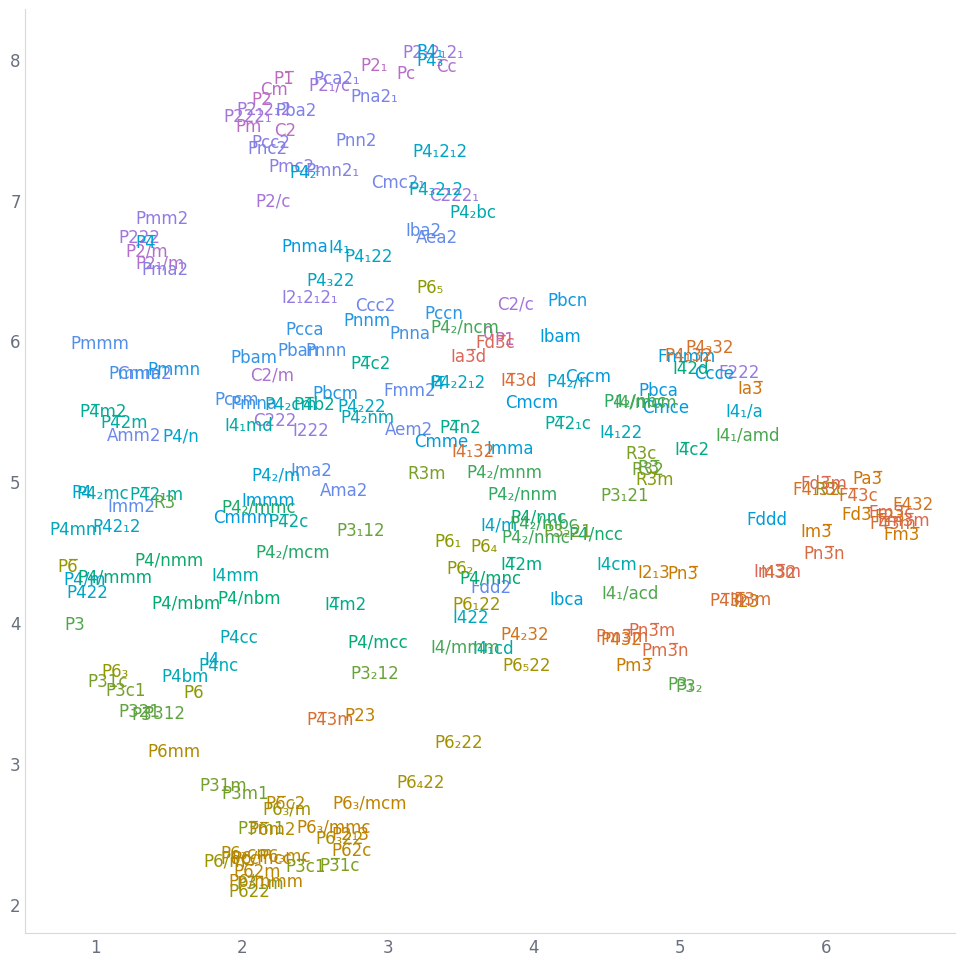

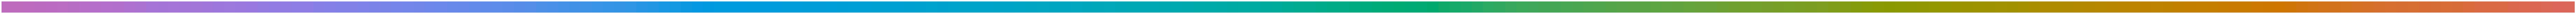

In [20]:
from sklearn.decomposition import PCA
from umap import UMAP
from baysic.utils import to_pretty_name

logging.basicConfig(level=logging.INFO, force=True)

fig, ax = plt.subplots(figsize=(12, 12))

groups = ['0'] + list(to_pretty_name(range(1, 231)))
mus = best.group_mu.detach().cpu().numpy()
num_comps, num_latent = mus.shape
mu_xy = UMAP(n_neighbors=30).fit_transform(mus)
group_colors = sns.color_palette('rho_iso_spectra', len(groups))

for group, group_xy, color in zip(groups, mu_xy, group_colors):
    ax.scatter(*group_xy, s=0)
    size = 12
    ax.text(*group_xy, group, fontdict=dict(color=color, size=size), ha='center', va='center')

sns.palplot(group_colors)

In [37]:
def group_predict(comp):
    grps = torch.arange(231).reshape(-1, 1)
    cmps = comp.reshape(-1, 290).expand(231, -1)
    return best.predict(cmps, grps)

val_dm = EFormDataModule(min_num=15, max_num=15)
val_dm.setup('test')

test_comps, test_groups, test_y = val_dm.test_set[0]
flow = group_predict(test_comps.reshape(-1, 1))
flow

NormalizingFlow(
  (transform): ComposedTransform(
    (0): AutoregressiveTransform()
    (1): AutoregressiveTransform()
    (2): AutoregressiveTransform()
  )
  (base): DiagNormal(loc: torch.Size([231, 1]), scale: torch.Size([231, 1]))
)

In [57]:
test_df

e_form
comp   group_num comp_ind          
Ti1Zr1 221       0        -6.176167
                 1        -5.813243
                 2        -8.049655
                 3        -7.134072
                 4        -6.967739
...                             ...
Au1Sb3 207       145      -3.032722
                 146      -0.731062
                 147      -3.706983
                 148      -0.881546
                 149      -1.655002

[1329447 rows x 1 columns]

In [70]:
flow.log_prob(torch.tensor([0.2, 0.4]).reshape(-1, 1)).shape

RuntimeError: Shape mismatch: objects cannot be broadcast to a single shape

/tmp/ipykernel_3525438/3240434406.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_e_forms = test_df.loc[test_comp, group.number]['e_form']


Text(0.5, 1.0, 'Ti1Zr1 P-62m')

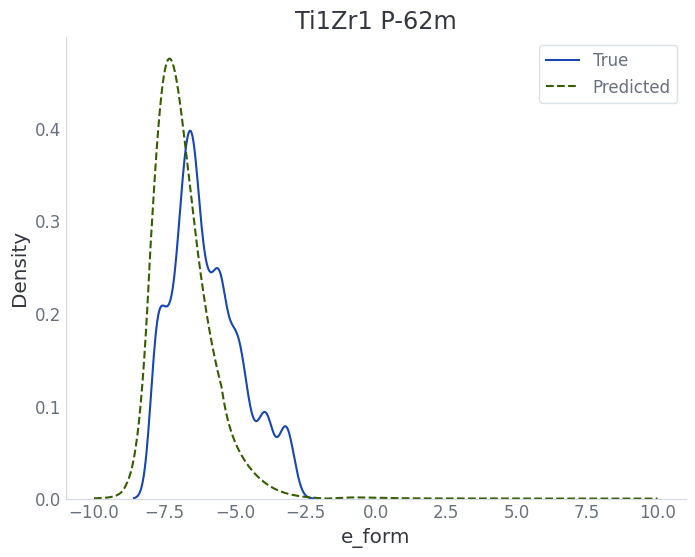

In [106]:
# from baysic.utils import full_symbols, to_np
from pyxtal import Group
test_set = val_dm.test_set.datasets[0]
test_df = test_set.df
test_comp = test_df.index[0][0]
group = Group(189)
test_e_forms = test_df.loc[test_comp, group.number]['e_form']

flow = group_predict(test_set[0][0].reshape(-1, 1))
scaled_xx = torch.linspace(0, 1, 1000).reshape(-1, 1, 1)
xx = test_set.e_form_scaler.inv(scaled_xx.reshape(-1))
log_probs = flow.log_prob(scaled_xx.expand(-1, 231, 1))[:, group.number]
jac = test_set.e_form_scaler.inv.log_abs_det_jacobian(xx, scaled_xx.reshape(-1))
yy = (log_probs - jac).exp().reshape(-1)

sns.kdeplot(test_e_forms, label='True', bw_adjust=0.5)
sns.lineplot(x=to_np(xx), y=to_np(yy), label='Predicted', ls='--')
plt.legend()
plt.title(f'{test_comp} {group.symbol}')

In [109]:
ridge_plot?

Signature:
ridge_plot(
    df: pandas.core.frame.DataFrame,
    group_var: str,
    num_var: str,
    order_by=<function <lambda> at 0x7f0196f42950>,
    height: int = 10,
    subplot_height: float = 0.8,
)
Docstring: <no docstring>
File:      ~/Dropbox/programs/baysic/baysic/viz.py
Type:      function

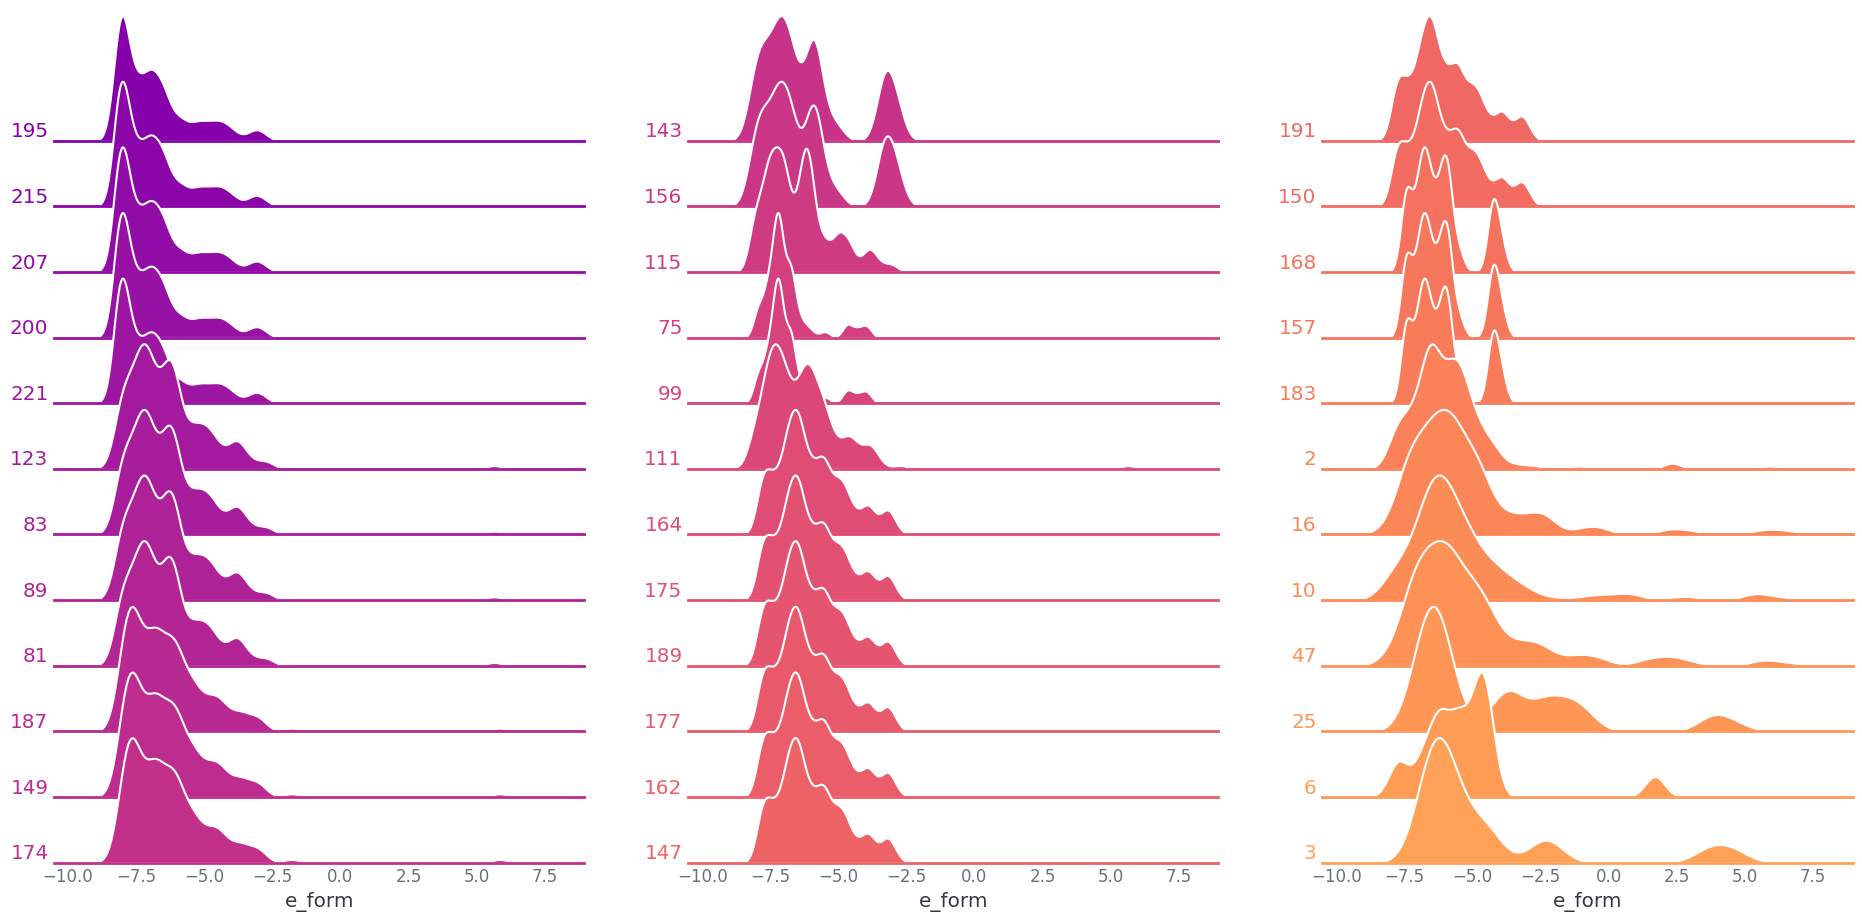

In [113]:
lattice_types = [Group(g).lattice_type for g in range(1, 231)]
test_df['lattice_type'] = [lattice_types[g] for g in test_df.index.get_level_values('group_num')]

ridge_plot(test_df.loc[test_comp].reset_index(), 'group_num', 'e_form', height=5)

In [ ]:
pred_df = np.array([group_predict(c_i) for c_i in torch.unique(X[:, 0])])
pred_df.shape

In [ ]:
from pyxtal import Group
idx = pd.MultiIndex.from_product([comps, groups, list('ABCDE')], names=['comp', 'group', 'cluster'])

pdf = pd.DataFrame(pred_df.transpose(0, 2, 3, 1).reshape(-1, 3), idx, ['pi', 'mu', 'sigma'])

# .melt(id_vars=['comp', 'cluster'], var_name='group', value_name='e_form_standardized')
pdf

In [ ]:
from baysic.utils import to_pretty_name
lattice_types = [Group(g).lattice_type for g in range(1, 231)]
symbols = to_pretty_name(np.arange(1, 231))
symbol_to_type = {k: v for k, v in zip(symbols, lattice_types)}
pdf['lattice_type'] = [symbol_to_type[g] for g in pdf.index.get_level_values('group')]
pdf

In [ ]:
# def plot_mix(subset, ax=None):
from os import close
from scipy.special import softmax
from scipy.stats import norm
import matplotlib.pyplot as plt


def plot_mixture(subset, ax=None, make_full_plot=True, **kwargs):
    if ax is None:
        ax = plt.gca()

    rough_xlim = (subset.eval('mu - 5 * sigma').min(), subset.eval('mu + 5 * sigma').max())
    rough_xx = np.linspace(*rough_xlim, 100)

    def probs(xx):
        probs = np.array([norm(row['mu'], row['sigma']).pdf(xx) for i, row in subset.iterrows()])
        probs *= softmax(subset['pi'].values.reshape(-1, 1))
        return probs

    rough_yy = probs(rough_xx).sum(axis=0)
    significant_support = (rough_yy / rough_yy.max()) >= 1e-2

    xx_support = rough_xx[significant_support]
    real_xlim = (xx_support.min(), xx_support.max())

    real_xx = np.linspace(*real_xlim, 1000)
    real_yy = probs(real_xx)
    yy = real_yy.sum(axis=0)
    closest_cluster = real_yy.argmax(axis=0)
    labels = subset.index.get_level_values('cluster')

    clust_colors = {}
    palette = cs
    curr_clust = closest_cluster[0]
    start_i = 0
    i = 1
    rcc = list(closest_cluster) + [None]
    while i < len(rcc):
        if rcc[i] == curr_clust:
            i += 1
        else:
            if curr_clust not in clust_colors:
                color = palette[len(clust_colors)]
                label = labels[curr_clust]
                clust_colors[curr_clust] = color
            else:
                color = clust_colors[curr_clust]
                label = None
            sns.lineplot(
                x=real_xx[start_i:i],
                y=yy[start_i:i],
                color=color,
                ax=ax,
                legend='auto' if make_full_plot else None,
                label=label,
            **kwargs)
            curr_clust = rcc[i]
            start_i = i
            i += 1

    if make_full_plot:
        ax.legend()
        ax.set_title('{}\n{}'.format(' '.join(subset.index.get_level_values('comp').unique()), subset.index.get_level_values('group').values[0]))

from pyxtal import Group
group = to_pretty_name(pd.Series([Group('Pm-3m').number]))[0]
subset = pdf.query('comp in @test_comps and group == @group')
plot_mixture(subset)

In [ ]:
test_comps = [comps[7]]
actual_data = df_test.query('comp in @test_comps')
actual_data['group'] = actual_data['group_symbol'].astype(str)
actual_groups = actual_data['group_symbol'].unique()

pdf_data = pdf.loc[test_comps, actual_groups, :]

g = sns.displot(
    actual_data,
    x='e_form',
    col='group',
    col_wrap=8,
    height=2.5,
    aspect=1.5,
    kind='kde',
    bw_adjust=0.3,
    lw=1.5,
    facet_kws=dict(sharey=False),
    color=cs[6],
    common_norm=False
)

g.set_titles(template='{col_name}')
g.fig.suptitle(', '.join(test_comps) if len(test_comps) < 20 else 'Many Compositions')

def add_predictions(data, **kwargs):
    group = data['group'].values[0]
    subset = pdf_data.loc[:, group, :]
    ax = plt.gca()
    if len(subset):
        lo, hi = ax.get_xlim()
        plot_mixture(subset, make_full_plot=False, linestyle='--', lw=1)
        ax.set_xlim(lo, hi)

g.map_dataframe(add_predictions)
g.add_legend()

In [ ]:
g.axes

In [ ]:
preds = pdf.query('w > 0.1').groupby(['comp', 'lattice_type']).min('e_form_standardized').unstack(level=1)
preds.columns = preds.columns.droplevel(0)
preds.idxmin(axis=1).loc['Ac2Tb6']

In [ ]:
from pyxtal import Group

df_valid = pd.read_feather('system_prediction.feather')

comps = pd.Series(comps)
y_system = df_valid.loc[comps[comps.isin(df_valid.index)].values, 'target']

In [ ]:
import seaborn as sns
import sklearn.metrics as metrics

palette = sns.color_palette('dark:#730aff', as_cmap=True)
preds = preds.loc[y_system.index].idxmin(axis=1)
use_resample=False

sample_weight = 1 / y_system.value_counts().loc[y_system] if use_resample else np.ones_like(y_system)
sample_weight /= np.sum(sample_weight)

order = ['triclinic', 'monoclinic', 'orthorhombic', 'tetragonal', 'hexagonal', 'cubic']
conf_mat = metrics.confusion_matrix(y_system, preds, labels=order, normalize='true').astype(float)
sns.heatmap(conf_mat, annot=True, xticklabels=order, yticklabels=order, cmap=palette, fmt='.0%')
plt.title('\n'.join([
    'MCC: {:.3f}'.format(metrics.matthews_corrcoef(y_system, preds, sample_weight=sample_weight)),
    'F1: {:.3f}'.format(metrics.f1_score(y_system, preds, average='weighted')),
    'Accuracy: {:.3f}'.format(metrics.accuracy_score(y_system, preds, sample_weight=sample_weight))
]))